<header>
    <h1> Physics 152 Project - Gravitational Strong Lensing</h1>
</header>

<h2> Section I: Introduction </h2>

For my project I am using strong lensing data taken from a certain galaxy cluster with a set mass model. If there is a source of light behind the central galaxy, the light from the source will bend and appear at a different location for an observer on earth (called the image points). Once the mass model of the galaxy and the image points are known, the positions of the source points can be numerically calculated by solving for the <a href="https://en.wikipedia.org/wiki/Gravitational_lensing_formalism"> deflection angle </a> which is an integral expression.

The code for creating the data (image and source positions) is stored in the UCSC Lux system. The data needed for this notebook is stored as 'MLdata.csv' in this directory. There are 10,000 inputs in the training dataset with 2 features each to determine the position of each image on a plane. The inputs here are chosen to be random uniformly distributed image points. The true source positions are solved for by a non linear solver (the above mentioned intergral expression) for a specific lensing (mass) model. The comparison between the true values and the predicted values from the neural net will be done by comparing the distances between the true sources and the predicted sources (regression model).

<h2> Section II: Data </h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from tqdm import tqdm

import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# I will be using a csv file for my data

df_original = pd.read_csv('MLdata.csv')
df_original.columns = df_original.columns.str.replace(' ', '')
df = df_original.sort_values(by=['img_train_x']) # created to show the sorted data
df_original # showing the dataframe sorted by the x img train

,img_train_x,img_train_y,src_train_x,src_train_y,img_test_x,img_test_y,src_test_x,src_test_y
0,7.858767,-8.554427,-1.113931,2.603239,-16.540898,3.366577,0.812498,-2.553141
1,-10.925942,2.052591,4.405556,-3.207238,-1.089924,8.104905,1.490085,-9.140212
2,8.778759,-3.075742,-2.364317,-2.211728,-1.535758,16.440244,0.078532,-5.788795
3,19.230568,7.393190,3.156495,-5.854869,-18.675542,10.046276,-2.481023,-2.317718
4,-0.762724,-4.315299,4.376730,1.882654,0.046374,-8.374269,4.029644,5.108333
...,...,...,...,...,...,...,...,...
9995,2.285836,-13.642959,3.274724,5.567833,NaN,NaN,NaN,NaN
9996,0.941036,8.989345,0.985249,-9.046913,NaN,NaN,NaN,NaN
9997,14.611054,11.912789,2.078535,-6.236964,NaN,NaN,NaN,NaN
9998,-14.915393,-2.197066,2.337259,-0.912701,NaN,NaN,NaN,NaN


In this dataframe every two columns represent an input (images) or an output (sources). Therefore, there are a 10,000 training data points that have 2 input features and 2 output features which corresponds to each image position and source position having an x and y coordinate. There are a 500 test data points (values for index >= 500 are given as null/NaN). The input dataset has been taken from a uniform distribution on the range of (-20, 20).

In [3]:
img_train_x = df_original.iloc[:, 0]
img_train_y = df_original.iloc[:, 1]

src_train_x = df_original.iloc[:, 2]
src_train_y = df_original.iloc[:, 3]

#showing the max and min of the training data
print(f'Training x max: {max(img_train_x)}')
print(f'Training x min: {min(img_train_x)}')

print(f'Training y max: {max(img_train_y)}')
print(f'Training y min: {min(img_train_y)}')

Training x max: 19.985253154468936
Training x min: -19.996724495453293
Training y max: 19.995602581839957
Training y min: -19.997286467509


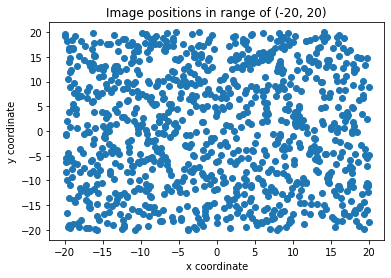

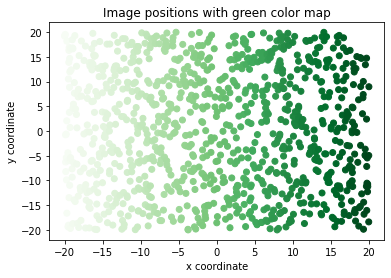

In [4]:
# plotting inputs of the training data up to a 1000 values (more than 1000 makes the plot cluttered)

# taking subset of the original data which is then sorted to make the color map more meaningful
plt_df = df_original.iloc[0:1000, :].sort_values(by=['img_train_x'])
plt_df

xplt_img = plt_df.iloc[:, 0]
yplt_img = plt_df.iloc[:, 1]

plt.scatter(xplt_img, yplt_img)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Image positions in range of (-20, 20)')
plt.show()

plt.scatter(xplt_img, yplt_img, c=np.arange(0.5, 1.5, 1/len(xplt_img)), cmap='Greens') 
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Image positions with green color map')
plt.show()

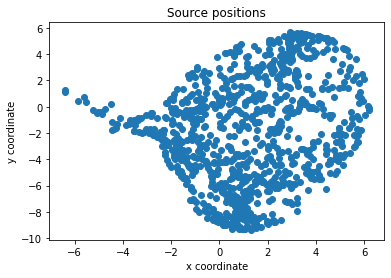

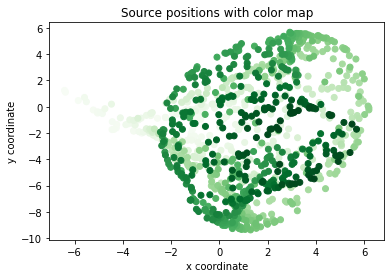

In [5]:
# plotting outputs of training data

xplt_src = plt_df.iloc[:, 2]
yplt_src =  plt_df.iloc[:, 3]

plt.scatter(xplt_src, yplt_src)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Source positions')
plt.show()

plt.scatter(xplt_src, yplt_src, c=np.arange(0, 1, 1/len(xplt_src)), cmap='Greens') 
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Source positions with color map')
plt.show()

Creating torch tensors for the training.

In [6]:
img_train = np.array(df_original[['img_train_x', 'img_train_y']].values.tolist())
src_train = np.array(df_original[['src_train_x', 'src_train_y']].values.tolist())
img_test = np.array(df_original[['img_test_x', 'img_test_y']].values.tolist())
src_test = np.array(df_original[['src_test_x', 'src_test_y']].values.tolist())

#removing NaN values from test arrays
img_test = img_test[np.isfinite(img_test)]
img_test = img_test.reshape(-1, 2)
src_test = src_test[np.isfinite(src_test)]
src_test = src_test.reshape(-1, 2)

To get better results, I used the standard scaler from sklearn to rescale the dataset. This put the values in a range of {-2, 2]. To use an activation function like tanh it makes sense to convert this to a range of [-1, 1] which I did by dividing the dataset by 2 after standard scaler was run.

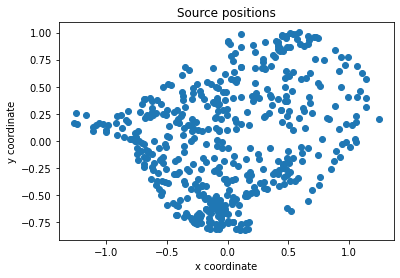

In [7]:
# scaling the values down to get lower loss values

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

img_train = sc.fit_transform(img_train)/2
img_test = sc.fit_transform(img_test)/2

src_train = sc.fit_transform(src_train)/2
src_test = sc.fit_transform(src_test)/2

# plotting source tests once scaled 

plt.scatter(src_test[0:999][:, 0], src_test[0:999][:, 1])
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Source positions')
plt.show()

# sending to gpu

img_trainT = torch.tensor(img_train, dtype=torch.float).to(device)
src_trainT = torch.tensor(src_train, dtype=torch.float).to(device)
img_testT = torch.tensor(img_test, dtype=torch.float).to(device)
src_testT = torch.tensor(src_test, dtype=torch.float).to(device)

<h2> Section III: Neural Network </h2>

As mentioned above there are around 10,000 training inputs and 10,000 outputs. Both the inputs and outputs have 2 features which define the position on the a 2-D plane. The number of parameters were planned to be between 10-15% of the size of the input dataset. The final number ended up being 14.12% (1412) of the input size. The structure was chosen to be  2 -> 30 -> 40 -> 2 since it falls within the this range. There are only two hidden layers as that seemed enough to reach the 10-15% range. The hidden layers are connected through the ReLU since the function relating the inputs and outputs is a non-linear function. Addtionally, ending with a tanh activation function is the best choice as the final outputs have both negative and positive values.

In [8]:
# creating network 
net = torch.nn.Sequential(torch.nn.Linear(2, 30),
                          torch.nn.ReLU(),
                           torch.nn.Linear(30, 40), 
                           torch.nn.ReLU(),
                           torch.nn.Linear(40, 2),
                          torch.nn.Tanh()
                         )

net.to(device)

torch.save(net.state_dict(), 'net.pth') # saving the network

params = np.sum([np.prod(theta.shape) for theta in net.parameters()])
print(f'Number of parameters: {params}')

Number of parameters: 1412


<h2> Section IV: Parameters </h2>

The choice for the loss function is the MSEloss as we want to minimize the distance between the predicted source positions and the true source positions. The learning rate was chosen to be 0.01 as that seemed to given a decreasing loss without too much noise. The batch size was chosen to be 500 as it splits the dataset in 20 batches which seemed to ensure that the training does not take too long while also giving a decreasing loss. The number epochs chosen were 1000 which seemed to cover the part where the loss was decreasing. Higher number of epochs would not have helped as the loss started to plateau earlier than 1000 epochs. I chose to try both the Adam and Stocastic Gradient Descent (with intial momentum of 0.9) optimizers to compare the two.

In [9]:
loss_fn = torch.nn.MSELoss()

# SDG and Adam optimizers to compare
optimizer1 = torch.optim.Adam(net.parameters(), lr=0.01)
optimizer2 = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# creating the minibatch loader
img_src_train = torch.utils.data.TensorDataset(img_trainT, src_trainT)
loader = torch.utils.data.DataLoader(img_src_train, batch_size=500, shuffle=True)

<h2> Section V: Execution </h2>


The training and test losses seem to decrease steadily. There are no signs of overtraining or being stuck in a local minimum. Longer epochs would not have helped the loss curves as the losses were starting to plateau before reaching the 1000 epochs limit. 

The SGD optimizer seems to have a less noisy loss curve compared to the Adam optimizer although both reach the same loss values at the end.

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.17it/s]


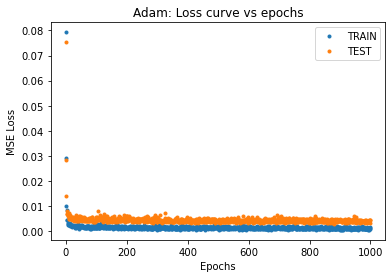

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.80it/s]


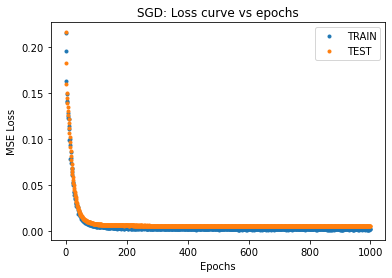

In [10]:
# creating a function that runs the loop given the optimizer

def runNN(optimizer, batch_size=500):

    loader = torch.utils.data.DataLoader(img_src_train, batch_size=batch_size, shuffle=True)
    
    loss_train, loss_test = [], [] # arrays to plot differences in losses

    torch.manual_seed(123)
    net.load_state_dict(torch.load('net.pth'))

    for epoch in tqdm(range(1000)):
        net.train()
    
        for img_batch, src_batch in loader:
            # training the model
            src_pred = net(img_batch) 
            loss_tr = loss_fn(src_pred, src_batch)
            optimizer.zero_grad()
            loss_tr.backward()
            optimizer.step()
        loss_train.append(loss_tr.cpu().data)
    
        # evaluating the model
        net.eval()
        src_pred_test = net(img_testT)
        loss_te = loss_fn(src_pred_test, src_testT)
        loss_test.append(loss_te.cpu().data)

    return loss_train, loss_test

loss_train, loss_test = runNN(optimizer1)
plt.plot(loss_train, '.', label='TRAIN')
plt.plot(loss_test, '.', label='TEST')
plt.legend()
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.title('Adam: Loss curve vs epochs')
plt.show()


loss_train, loss_test = runNN(optimizer2)
plt.plot(loss_train, '.', label='TRAIN')
plt.plot(loss_test, '.', label='TEST')
plt.legend()
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.title('SGD: Loss curve vs epochs')
plt.show()

<h2> Section VI: Results </h2>


The bias and variance of the predicted minus the test data seem reasonable. Having reasonable bias and variance means that the predicted source positons are close enough to the true source positions. This implies that the machine learning model can be used to find the source positions using the same inputs with a small degree of error. Using machine learning in this case is beneficial because it is not very computationally expensive (can be done in a reasonable amount of time by everyday machines) compared to solving the true source positions using the integral expression which is more computationally expensive and takes a notable amount of time on the Lux supercomputer system. 

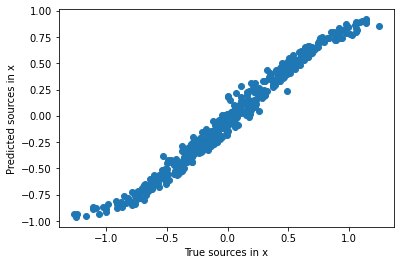

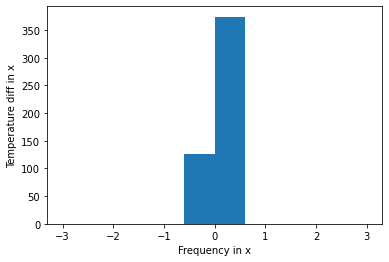

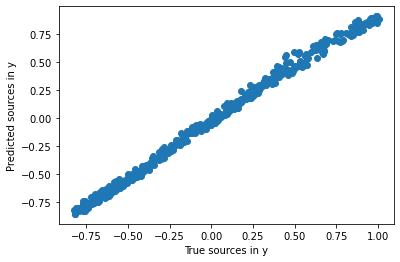

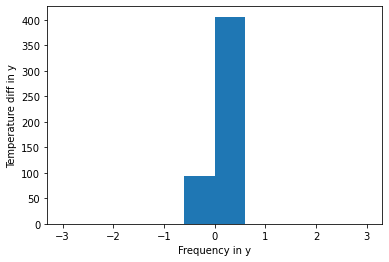

Bias = 0.08472714573144913
Variance = 0.003381554502993822
Standard deviation = 0.05815113501036607


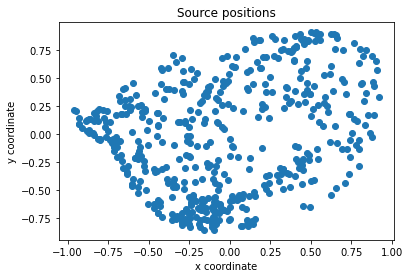

In [11]:
net.eval()
src_pred = net(img_testT).cpu().data

diff = np.array(src_testT.cpu() - src_pred)
dist = np.linalg.norm(diff, axis=1)

# src_x plots

plt.scatter(src_testT.cpu()[:, 0], src_pred[:, 0])
plt.xlabel('True sources in x')
plt.ylabel('Predicted sources in x')
plt.show()


plt.hist(diff[:, 0], bins=10, range=[-3,3])
plt.xlabel('Frequency in x')
plt.ylabel('Temperature diff in x')
plt.show()


#src_y plots

plt.scatter(src_testT.cpu()[:, 1], src_pred[:, 1])
plt.xlabel('True sources in y')
plt.ylabel('Predicted sources in y')
plt.show()

plt.hist(diff[:, 1], bins=10, range=[-3,3])
plt.xlabel('Frequency in y')
plt.ylabel('Temperature diff in y')
plt.show()

print(f'Bias = {np.mean(dist)}')
print(f'Variance = {np.var(dist)}')
print(f'Standard deviation = {np.var(dist)**0.5}')

# entire src positons in the plane
plt.scatter(src_pred[:, 0], src_pred[:, 1])
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Source positions')
plt.show()


<h2> Section VII: Optimization </h2>

To optimize the network, I scanned over a range of momentums, learning rates, and batch sizes using the SGD optimizer and compared the training losses. The training losses were compared by looking at the average of the last 10 elements of the training loss for each hyperparameter. I did not chose to include the number of epochs as the loss is not decreasing much beyond 600 epochs. I did not change the size of the network either because the loss curves did not change much between the range of 1000 to 1500 when I was setting up the intial network structure. From the optimization, I found that the momentums of 0.8 and 0.9 were the best options. Most learning rates appear to give around the same results. However, the 0.01 learning rate seems to give the least noisy loss curve. The batch sizes did not change the loss curves significantly either. The batch size of 750 seemed to give less noisy results.

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:42<00:00,  9.75it/s]


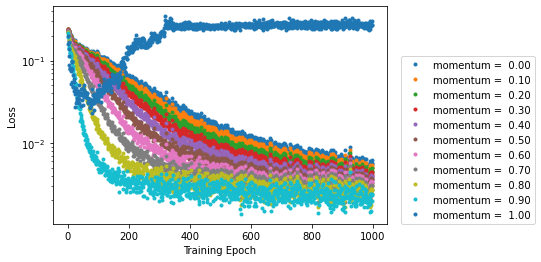

  0%|                                                                                 | 1/1000 [00:00<01:41,  9.88it/s]

The best momentum is 0.9


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.67it/s]


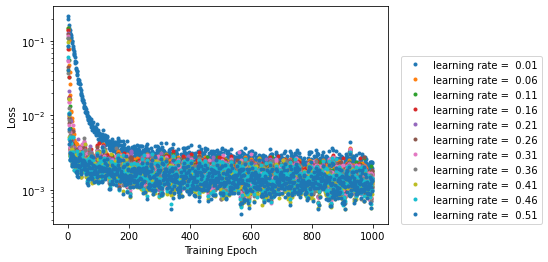

  0%|                                                                                 | 1/1000 [00:00<02:13,  7.46it/s]

The best learning rate is 0.51. However, most learning rates appear good


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.33it/s]


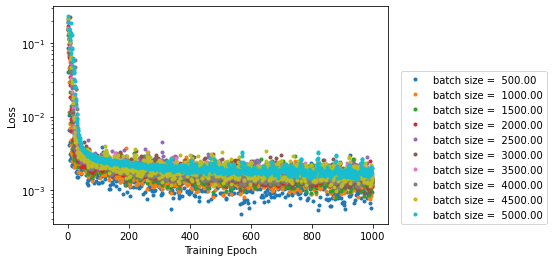

The best batch size is 500. However, most batch sizes appear good.


In [12]:
# I will be comparing taking the value of the learning rate, momentum or batch size that minimizes the training loss    

# Scanning over different momentum 

def takeLowestLossAvg(arr):
    temp = arr[-10:]
    return np.mean(temp)

momentum_arr = np.arange(0, 1.1, 0.1)
p_best = 0
lowestLoss = 0
for p in momentum_arr:
    train_loss, test_loss = runNN(torch.optim.SGD(net.parameters(), lr=0.01, momentum=p))
    if p == 0:
        lowestLoss = takeLowestLossAvg(train_loss)
    if lowestLoss > takeLowestLossAvg(train_loss):
        p_best = p
    plt.plot(train_loss, '.', label=f'momentum = {p: .2f}')
    plt.legend(loc=(1.04, 0))
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
plt.show()

print(f'The best momentum is {p_best}')
    
# Scanning over different learning rate

learning_rates = np.arange(0.01, 0.52, 0.05)
lr_best = 0.01
lowestLoss = 0
for lr in learning_rates:
    train_loss, test_loss = runNN(torch.optim.SGD(net.parameters(), lr=lr, momentum=p_best))
    if lr == 0.01:
        lowestLoss = takeLowestLossAvg(train_loss)
    if lowestLoss > takeLowestLossAvg(train_loss):
        lr_best = lr
    plt.plot(train_loss, '.', label=f'learning rate = {lr: .2f}')
    plt.legend(loc=(1.04, 0))
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
plt.show()

print(f'The best learning rate is {lr_best}. However, most learning rates appear good')

# Scanning over different batch size

batch_sizes = np.arange(500, 5001, 500)
batch_best = 500
lowestLoss = 0
for batch in batch_sizes:
    train_loss, test_loss = runNN(torch.optim.SGD(net.parameters(), lr=lr_best, momentum=p_best), batch_size=int(batch))
    if int(batch) == 500:
        lowestLoss = takeLowestLossAvg(train_loss)
    if lowestLoss > takeLowestLossAvg(train_loss):
        batch_best = batch
    plt.plot(train_loss, '.', label=f'batch size = {batch: .2f}')
    plt.legend(loc=(1.04, 0))
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
plt.show()

print(f'The best batch size is {batch_best}. However, most batch sizes appear good.')

Recreating the earlier plots with better hyperparameters.

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.76it/s]


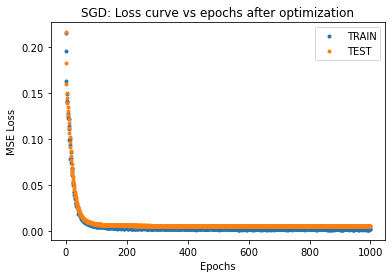

In [13]:
train_loss, test_loss = runNN(torch.optim.SGD(net.parameters(), lr=lr_best, momentum=p_best), batch_size=batch_best)
plt.plot(loss_train, '.', label='TRAIN')
plt.plot(loss_test, '.', label='TEST')
plt.legend()
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.title('SGD: Loss curve vs epochs after optimization')
plt.show()

Going through the results again.

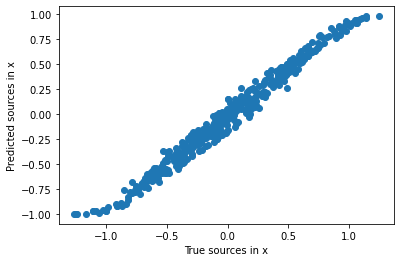

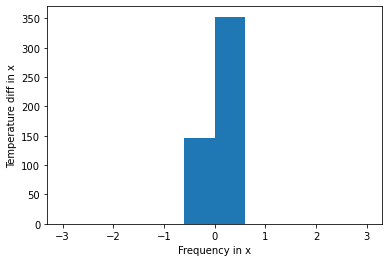

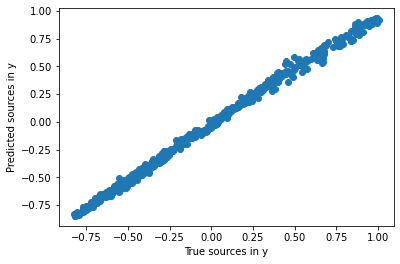

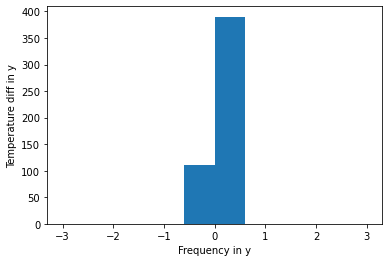

Bias = 0.07015353441238403
Variance = 0.002320310100913048
Standard deviation = 0.048169597267499004


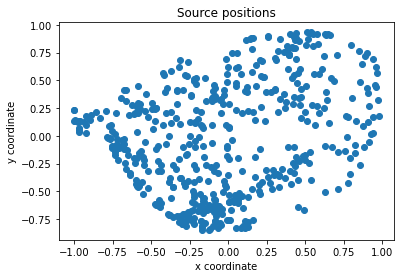

In [14]:
net.eval()
src_pred = net(img_testT).cpu().data

diff = np.array(src_testT.cpu() - src_pred)
dist = np.linalg.norm(diff, axis=1)

# src_x plots

plt.scatter(src_testT.cpu()[:, 0], src_pred[:, 0])
plt.xlabel('True sources in x')
plt.ylabel('Predicted sources in x')
plt.show()


plt.hist(diff[:, 0], bins=10, range=[-3,3])
plt.xlabel('Frequency in x')
plt.ylabel('Temperature diff in x')
plt.show()


#src_y plots

plt.scatter(src_testT.cpu()[:, 1], src_pred[:, 1])
plt.xlabel('True sources in y')
plt.ylabel('Predicted sources in y')
plt.show()

plt.hist(diff[:, 1], bins=10, range=[-3,3])
plt.xlabel('Frequency in y')
plt.ylabel('Temperature diff in y')
plt.show()

print(f'Bias = {np.mean(dist)}')
print(f'Variance = {np.var(dist)}')
print(f'Standard deviation = {np.var(dist)**0.5}')

# entire src positons in the plane
plt.scatter(src_pred[:, 0], src_pred[:, 1])
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Source positions')
plt.show()

Bias and variance are slightly better after optimization which shows that the optimization was useful.